In [142]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [157]:
import os
import re
import h5py
import numpy as np
from tqdm import tqdm


In [144]:
def load_h5_slice(filepath):
    with h5py.File(filepath, "r") as f:
        image = f["image"][:]
        mask  = f["mask"][:]
    return image, mask


In [152]:
def preprocess_image(image):
    return (image - image.mean()) / (image.std() + 1e-8)


In [153]:
def preprocess_subject(h5_dir, subject_id, save_dir):
    os.makedirs(save_dir, exist_ok=True)

    X_list, Y_list = [], []

    slice_files = sorted([f for f in os.listdir(h5_dir)
                          if f.startswith(f"volume_{subject_id}_")])

    print(f"Subject {subject_id}: {len(slice_files)} slices")

    for fname in slice_files:
        path = os.path.join(h5_dir, fname)
        image, mask_oh = load_h5_slice(path)

        image = preprocess_image(image)
        mask = np.argmax(mask_oh, axis=-1)   # categorical mask (240,240)

        X_list.append(image)
        Y_list.append(mask)

    X = np.array(X_list)
    Y = np.array(Y_list)

    np.save(os.path.join(save_dir, f"volume_{subject_id}_X.npy"), X)
    np.save(os.path.join(save_dir, f"volume_{subject_id}_Y.npy"), Y)


In [154]:
def get_all_subject_ids(h5_dir):
    ids = set()
    for fname in os.listdir(h5_dir):
        m = re.match(r"volume_(\d+)_slice", fname)
        if m:
            ids.add(int(m.group(1)))
    return sorted(list(ids))


In [155]:
h5_dir = "/content/drive/MyDrive/BME-AIML-Final-Project/archive/BraTS2020_training_data/content/data"
save_root = "/content/drive/MyDrive/BME-AIML-Final-Project/preprocessed_dataset"


all_subjects = get_all_subject_ids(h5_dir)
subjects = all_subjects[:20]

for sid in tqdm(subjects):
    preprocess_subject(h5_dir, sid, save_root)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/BME-AIML-Final-Project/archive/BraTS2020_training_data/content/data'

In [ ]:
import os
import numpy as np

save_root = "/content/drive/MyDrive/BME-AIML-Final-Project/preprocessed_dataset"

X_list = []
Y_list = []

files = sorted(os.listdir(save_root))

for fname in files:
    if fname.endswith("_X.npy"):
        subject_id = fname.split("_")[1]
        X = np.load(os.path.join(save_root, f"volume_{subject_id}_X.npy"))
        Y = np.load(os.path.join(save_root, f"volume_{subject_id}_Y.npy"))

        X_list.append(X)
        Y_list.append(Y)

X_all = np.concatenate(X_list, axis=0)
Y_all = np.concatenate(Y_list, axis=0)

print("Merged X_all:", X_all.shape)
print("Merged Y_all:", Y_all.shape)


Merged X_all: (2325, 240, 240, 4)
Merged Y_all: (2325, 240, 240)


In [150]:
tumor_indices = [i for i in range(len(Y_all)) if np.sum(Y_all[i] > 0) > 50]

X_clean = X_all[tumor_indices]
Y_clean = Y_all[tumor_indices]

print("X_clean:", X_clean.shape)
print("Y_clean:", Y_clean.shape)


X_clean: (335, 240, 240, 4)
Y_clean: (335, 240, 240)


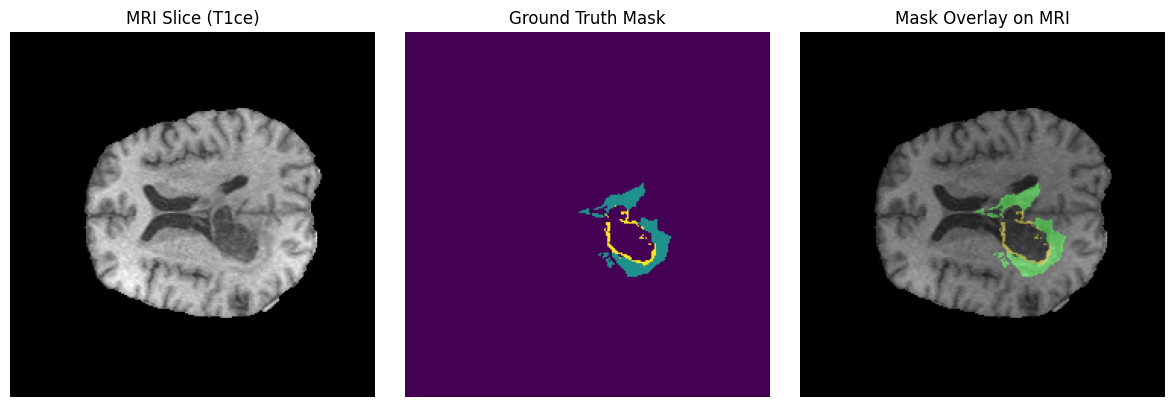

In [ ]:
def overlay_mask(mri, mask, alpha=0.35):
    mri = (mri - mri.min()) / (mri.max() - mri.min() + 1e-8)
    mri_rgb = np.stack([mri]*3, axis=-1)

    colors = {
        1: np.array([0,1,0]),    # edema = green
        2: np.array([1,1,0])     # enhancing tumor = yellow
    }

    overlay = np.zeros_like(mri_rgb)
    for cls, color in colors.items():
        overlay[mask == cls] = color

    return (1 - alpha)*mri_rgb + alpha*overlay

def visualize_overlay(X_all, Y_all, idx=None):
    if idx is None:
        idx = np.random.randint(0, len(X_all))

    img = X_all[idx][:,:,1]
    mask = Y_all[idx]

    combined = overlay_mask(img, mask)

    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.imshow(img, cmap='gray')
    plt.title("MRI Slice (T1ce)")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(mask, cmap="viridis")
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(combined)
    plt.title("Mask Overlay on MRI")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

visualize_overlay(X_all, Y_all)


In [ ]:
print("Total slices:", len(X_all))
unique_masks = np.unique(Y_all)
print("Unique segmentation labels:", unique_masks)

tumor_slices = (Y_all > 0).reshape(len(Y_all), -1).any(axis=1).sum()
print("Tumor slices:", tumor_slices)
print("Non-tumor slices:", len(Y_all) - tumor_slices)


Total slices: 2325
Unique segmentation labels: [0 1 2]
Tumor slices: 963
Non-tumor slices: 1362


In [158]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class BrainTumorDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = torch.tensor(self.X[idx], dtype=torch.float32).permute(2,0,1)  # (4,240,240)
        mask = torch.tensor(self.Y[idx], dtype=torch.long)                  # (240,240)
        return img, mask

dataset = BrainTumorDataset(X_clean, Y_clean)

train_set, val_set = train_test_split(
    list(range(len(dataset))), test_size=0.2, random_state=42
)

train_loader = DataLoader([dataset[i] for i in train_set], batch_size=4, shuffle=True)
val_loader   = DataLoader([dataset[i] for i in val_set], batch_size=4, shuffle=False)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))


Train batches: 67
Val batches: 17


In [159]:
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.net(x)

class UNet(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()

        self.down1 = DoubleConv(4, 16)
        self.pool1 = nn.MaxPool2d(2)

        self.down2 = DoubleConv(16, 32)
        self.pool2 = nn.MaxPool2d(2)

        self.down3 = DoubleConv(32, 64)
        self.pool3 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(64, 128)

        self.up3 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv3 = DoubleConv(128, 64)

        self.up2 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.conv2 = DoubleConv(64, 32)

        self.up1 = nn.ConvTranspose2d(32, 16, 2, stride=2)
        self.conv1 = DoubleConv(32, 16)

        self.out = nn.Conv2d(16, num_classes, 1)

    def forward(self, x):
        c1 = self.down1(x)
        p1 = self.pool1(c1)

        c2 = self.down2(p1)
        p2 = self.pool2(c2)

        c3 = self.down3(p2)
        p3 = self.pool3(c3)

        bn = self.bottleneck(p3)

        u3 = self.up3(bn)
        merge3 = torch.cat([u3, c3], dim=1)
        c4 = self.conv3(merge3)

        u2 = self.up2(c4)
        merge2 = torch.cat([u2, c2], dim=1)
        c5 = self.conv2(merge2)

        u1 = self.up1(c5)
        merge1 = torch.cat([u1, c1], dim=1)
        c6 = self.conv1(merge1)

        return self.out(c6)


In [160]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

epochs = 10

for epoch in range(epochs):
    model.train()
    train_loss = 0

    for img, mask in train_loader:
        img = img.to(device)
        mask = mask.to(device)

        optimizer.zero_grad()
        logits = model(img)
        loss = criterion(logits, mask)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print(f"Epoch {epoch+1} train loss: {train_loss/len(train_loader):.4f}")


Epoch 1 train loss: 0.9872
Epoch 2 train loss: 0.1400
Epoch 3 train loss: 0.0891
Epoch 4 train loss: 0.0800
Epoch 5 train loss: 0.0617
Epoch 6 train loss: 0.0451
Epoch 7 train loss: 0.0414
Epoch 8 train loss: 0.0377
Epoch 9 train loss: 0.0368
Epoch 10 train loss: 0.0337


In [161]:
loss_history = []

for epoch in range(10):
    model.train()
    train_loss = 0

    for img, mask in train_loader:
        img = img.to(device)
        mask = mask.to(device)

        optimizer.zero_grad()
        out = model(img)
        loss = criterion(out, mask)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader)
    loss_history.append(avg_loss)

    print(f"Epoch {epoch+1}, Training Loss = {avg_loss:.4f}")



Epoch 1, Training Loss = 0.0328
Epoch 2, Training Loss = 0.0325
Epoch 3, Training Loss = 0.0315
Epoch 4, Training Loss = 0.0298
Epoch 5, Training Loss = 0.0287
Epoch 6, Training Loss = 0.0279
Epoch 7, Training Loss = 0.0268
Epoch 8, Training Loss = 0.0271
Epoch 9, Training Loss = 0.0258
Epoch 10, Training Loss = 0.0267


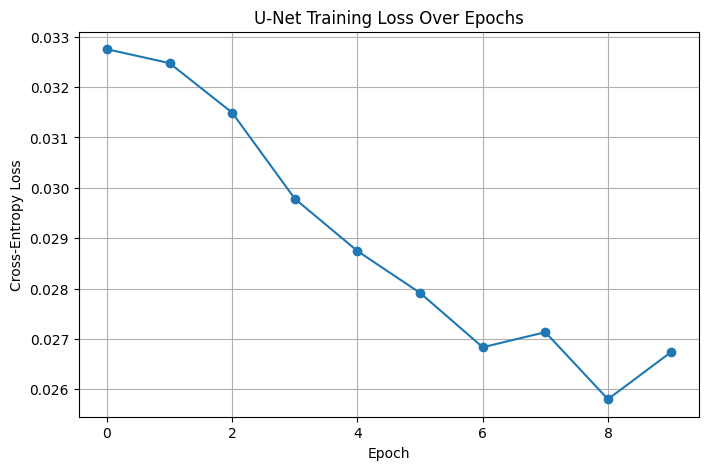

In [162]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(loss_history, marker='o')
plt.title("U-Net Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.grid(True)
plt.show()


In [ ]:
Y_clean = np.array(Y_clean)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

def mask_to_onehot(mask, num_classes=3):
    mask = torch.tensor(mask, dtype=torch.long)
    oh = F.one_hot(mask, num_classes=num_classes)
    return oh.permute(2,0,1).float()

class ImprovedMaskAE(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()

        self.enc = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),  # 240 → 120
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.Conv2d(32, 64, 4, stride=2, padding=1),  # 120 → 60
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, 4, stride=2, padding=1),  # 60 → 30
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
        )

        self.flat_dim = 256 * 30 * 30
        self.fc_enc = nn.Linear(self.flat_dim, latent_dim)

        self.fc_dec = nn.Linear(latent_dim, self.flat_dim)

        self.dec = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1), # 30 → 60
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), # 60 → 120
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  # 120 → 240
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 3, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        h = self.enc(x)
        h = h.view(h.size(0), -1)

        z = self.fc_enc(h)
        h2 = self.fc_dec(z)

        h2 = h2.view(-1, 256, 30, 30)
        x_hat = self.dec(h2)

        return x_hat, z



Using: cuda


In [ ]:
ae = ImprovedMaskAE(latent_dim=128).to(device)

optimizer = torch.optim.Adam(ae.parameters(), lr=2e-4, weight_decay=1e-5)
loss_fn = nn.MSELoss()

epochs = 50

for epoch in range(epochs):
    ae.train()
    total = 0

    for y in Y_clean:
        y_oh = mask_to_onehot(y).unsqueeze(0).to(device)

        optimizer.zero_grad()
        y_hat, z = ae(y_oh)

        loss = loss_fn(y_hat, y_oh)
        loss.backward()
        optimizer.step()

        total += loss.item()

    print(f"Epoch {epoch+1}/{epochs} | Loss = {total/len(Y_clean):.5f}")



Training improved autoencoder...

Epoch 1/50 | Loss = 0.01770
Epoch 2/50 | Loss = 0.00893
Epoch 3/50 | Loss = 0.01036
Epoch 4/50 | Loss = 0.01024
Epoch 5/50 | Loss = 0.00987
Epoch 6/50 | Loss = 0.00955
Epoch 7/50 | Loss = 0.00945
Epoch 8/50 | Loss = 0.00876
Epoch 9/50 | Loss = 0.00828
Epoch 10/50 | Loss = 0.00766
Epoch 11/50 | Loss = 0.00683
Epoch 12/50 | Loss = 0.00628
Epoch 13/50 | Loss = 0.00574
Epoch 14/50 | Loss = 0.00543
Epoch 15/50 | Loss = 0.00504
Epoch 16/50 | Loss = 0.00462
Epoch 17/50 | Loss = 0.00436
Epoch 18/50 | Loss = 0.00410
Epoch 19/50 | Loss = 0.00395
Epoch 20/50 | Loss = 0.00387
Epoch 21/50 | Loss = 0.00361
Epoch 22/50 | Loss = 0.00351
Epoch 23/50 | Loss = 0.00340
Epoch 24/50 | Loss = 0.00329
Epoch 25/50 | Loss = 0.00315
Epoch 26/50 | Loss = 0.00308
Epoch 27/50 | Loss = 0.00302
Epoch 28/50 | Loss = 0.00290
Epoch 29/50 | Loss = 0.00279
Epoch 30/50 | Loss = 0.00281
Epoch 31/50 | Loss = 0.00277
Epoch 32/50 | Loss = 0.00270
Epoch 33/50 | Loss = 0.00261
Epoch 34/50 | Los

In [ ]:
def visualize_improved_ae(idx):
    ae.eval()
    y = Y_clean[idx]
    y_oh = mask_to_onehot(y).unsqueeze(0).to(device)

    with torch.no_grad():
        y_hat, z = ae(y_oh)

    recon = y_hat[0].cpu().numpy()
    recon_mask = recon.argmax(axis=0)

    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.imshow(y)
    plt.title("Original Mask")
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(recon_mask)
    plt.title("Reconstructed Mask")
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.plot(z.cpu().numpy())
    plt.title("Improved Latent (128-D)")
    plt.grid(True)

    plt.show()


In [10]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

print("Latents shape:", latents.shape)

tumor_sizes = np.array([np.sum(Y_clean[i] > 0) for i in range(len(Y_clean))])

tumor_sizes_norm = (tumor_sizes - tumor_sizes.min()) / (tumor_sizes.max() - tumor_sizes.min() + 1e-8)


NameError: name 'latents' is not defined

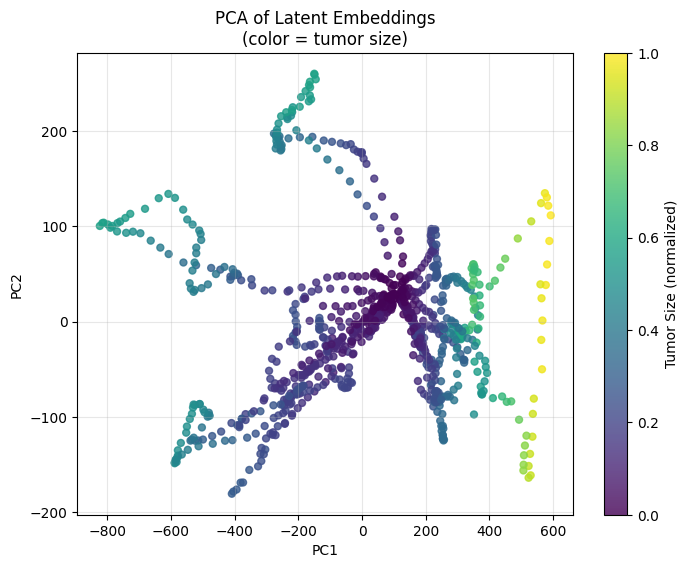

In [ ]:
pca = PCA(n_components=2)
latents_pca = pca.fit_transform(latents)

plt.figure(figsize=(8,6))
plt.scatter(latents_pca[:,0], latents_pca[:,1],
            c=tumor_sizes_norm, cmap='viridis', s=25, alpha=0.8)

plt.title("PCA of Latent Embeddings\n(color = tumor size)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Tumor Size (normalized)")
plt.grid(True, alpha=0.3)
plt.show()


In [11]:
ae.eval()
latents = []
tumor_sizes = []

with torch.no_grad():
    for y in Y_clean:

        y_oh = mask_to_onehot(y).unsqueeze(0).to(device)

        _, z = ae(y_oh)

        latents.append(z.cpu().numpy().flatten())

        tumor_sizes.append((y > 0).sum())

latents = np.array(latents)
tumor_sizes = np.array(tumor_sizes)

print("Latents shape:", latents.shape)
print("Tumor sizes shape:", tumor_sizes.shape)


NameError: name 'ae' is not defined

In [12]:
np.save("/content/drive/MyDrive/BME-AIML-Final-Project/ae_latents.npy", latents)
np.save("/content/drive/MyDrive/BME-AIML-Final-Project/tumor_sizes.npy", tumor_sizes)


NameError: name 'latents' is not defined

In [13]:
import numpy as np
import os

root = "/content/drive/MyDrive/BME-AIML-Final-Project/preprocessed_dataset"

all_masks = []

for fname in sorted(os.listdir(root)):
    if fname.endswith("_Y.npy"):
        path = os.path.join(root, fname)
        print("Loading:", fname)

        Y = np.load(path)

        if Y.ndim == 4 and Y.shape[-1] == 3:
            print("Converting from one-hot:", fname)
            Y = np.argmax(Y, axis=-1)

        all_masks.append(Y)

Y_clean = np.concatenate(all_masks, axis=0)
print("Final Y_clean shape:", Y_clean.shape)

# SAVE IT
save_path = "/content/drive/MyDrive/BME-AIML-Final-Project/Y_clean.npy"
np.save(save_path, Y_clean)


Loading: volume_10_Y.npy
Loading: volume_11_Y.npy
Loading: volume_12_Y.npy
Loading: volume_13_Y.npy
Loading: volume_14_Y.npy
Loading: volume_15_Y.npy
Loading: volume_16_Y.npy
Loading: volume_17_Y.npy
Loading: volume_18_Y.npy
Loading: volume_19_Y.npy
Loading: volume_1_Y.npy
Loading: volume_2_Y.npy
Loading: volume_3_Y.npy
Loading: volume_4_Y.npy
Loading: volume_5_Y.npy
Loading: volume_6_Y.npy
Loading: volume_7_Y.npy
Loading: volume_8_Y.npy
Loading: volume_9_Y.npy
Final Y_clean shape: (2945, 240, 240)

✓ Saved Y_clean.npy to /content/drive/MyDrive/BME-AIML-Final-Project/Y_clean.npy


In [14]:
import numpy as np
from sentence_transformers import SentenceTransformer, util


In [15]:
latents = np.load("/content/drive/MyDrive/BME-AIML-Final-Project/ae_latents.npy")
Y_clean = np.load("/content/drive/MyDrive/BME-AIML-Final-Project/Y_clean.npy")


In [16]:
!mkdir -p "/content/drive/MyDrive/BME-AIML-Final-Project/results"


In [127]:
from sentence_transformers import SentenceTransformer, util

bert_model = SentenceTransformer("all-MiniLM-L6-v2")


In [163]:
summary_library = [
    "No tumor in this slice.",
    "A small tumor is visible.",
    "A small tumor with uneven edges is visible.",
    "A medium-sized tumor with mostly smooth boundaries is visible.",
    "A medium-sized tumor with some uneven or irregular edges is visible.",
    "A large-sized tumor with mostly smooth boundaries is visible.",
    "A large tumor with some uneven or irregular edges is visible.",
    "A tumor that appears spread out or diffuse is visible.",
]

In [164]:
summary_embeddings = bert_model.encode(summary_library, convert_to_tensor=True)


In [165]:
from skimage.measure import perimeter

def extract_tumor_features(mask):
    area = np.sum(mask > 0)
    binmask = (mask > 0).astype(int)
    per = perimeter(binmask)
    complexity = per / (area + 1e-6)
    compactness = area / (per**2 + 1e-6)
    return area, complexity, compactness


In [166]:
def describe_size(area):
    if area == 0:
        return "absent"
    elif area < 300:
        return "small"
    elif area < 700:
        return "medium"
    else:
        return "large"


def describe_complexity(c):
    if c < 0.1:
        return "very smooth"
    elif c < 0.2:
        return "mostly smooth"
    elif c < 0.3:
        return "moderately irregular"
    else:
        return "highly irregular"

def describe_compactness(comp):
    if comp < 0.02:
        return "very low compactness"
    elif comp < 0.05:
        return "low compactness"
    else:
        return "high compactness"


In [167]:
def build_feature_text(area, complexity, compactness, latent_mean):
    if area == 0:
        return "No tumor detected."

    size_desc = describe_size(area)
    cplx_desc = describe_complexity(complexity)
    compact_desc = describe_compactness(compactness)

    return (
        f"This slice contains a {size_desc} tumor. "
        f"It has {cplx_desc} boundaries and {compact_desc}. "
        f"Overall, the tumor occupies a substantial region of the slice."
        if size_desc == "large"
        else
        f"This slice contains a {size_desc} tumor with {cplx_desc} boundaries and {compact_desc}."
    )


In [168]:
from sentence_transformers import util

def summarize_tumor(idx):
    mask = Y_clean[idx]
    latent = latents[idx]
    latent_mean = latent.mean()

    area, complexity, compactness = extract_tumor_features(mask)

    if area == 0:
        return {
            "raw_features": (area, complexity, compactness, latent_mean),
            "summary": "No tumor detected in this slice."
        }

    text = build_feature_text(area, complexity, compactness, latent_mean)

    text_emb = bert_model.encode(text, convert_to_tensor=True)

    # cosine similarity with summary library
    scores = util.cos_sim(text_emb, summary_embeddings)[0]
    best_idx = int(scores.argmax())

    return {
        "raw_features": (area, complexity, compactness, latent_mean),
        "summary": summary_library[best_idx]
    }



In [169]:
def print_tumor_summary(idx):
    result = summarize_tumor(idx)

    area, cplx, comp, lm = result["raw_features"]

    print("="*30)
    print(f"Tumor Slice {idx} Summary")
    print("="*30)
    print("\nRaw Features:")
    print(f" • Tumor size: {area}")
    print(f" • Complexity: {cplx:.3f}")
    print(f" • Compactness: {comp:.3f}")
    print(f" • Latent mean: {lm:.3f}")

    print("\nSelected Summary:")
    print(result["summary"])
    print("="*30 + "\n")


In [170]:
for i in range(20):
    print_tumor_summary(i)


Tumor Slice 0 Summary

Raw Features:
 • Tumor size: 1508
 • Complexity: 0.159
 • Compactness: 0.026
 • Latent mean: 0.024

Selected Summary:
No tumor in this slice.

Tumor Slice 1 Summary

Raw Features:
 • Tumor size: 1397
 • Complexity: 0.163
 • Compactness: 0.027
 • Latent mean: 0.009

Selected Summary:
No tumor in this slice.

Tumor Slice 2 Summary

Raw Features:
 • Tumor size: 1211
 • Complexity: 0.164
 • Compactness: 0.031
 • Latent mean: 0.017

Selected Summary:
No tumor in this slice.

Tumor Slice 3 Summary

Raw Features:
 • Tumor size: 1055
 • Complexity: 0.188
 • Compactness: 0.027
 • Latent mean: 0.007

Selected Summary:
No tumor in this slice.

Tumor Slice 4 Summary

Raw Features:
 • Tumor size: 966
 • Complexity: 0.197
 • Compactness: 0.027
 • Latent mean: 0.011

Selected Summary:
No tumor in this slice.

Tumor Slice 5 Summary

Raw Features:
 • Tumor size: 867
 • Complexity: 0.189
 • Compactness: 0.032
 • Latent mean: -0.006

Selected Summary:
No tumor in this slice.

Tumor

In [96]:
summarize_tumor(10)


{'raw_features': (np.int64(918),
  np.float64(0.27917126398083586),
  np.float64(0.013977062014075805),
  np.float32(0.0077467635)),
 'summary': 'A large tumor with mostly smooth edges covers part of the slice.'}

In [97]:
def summarize_tumor_debug(idx):
    mask = Y_clean[idx]
    latent = latents[idx]

    area, complexity, compactness = extract_tumor_features(mask)
    text = build_feature_text(area, complexity, compactness, latent)

    text_emb = bert_model.encode(text, convert_to_tensor=True)
    scores = util.cos_sim(text_emb, summary_embeddings)[0]

    print("\nRaw Feature Text:")
    print(text)

    print("\nCosine Similarity Scores:")
    for s, summary in sorted(zip(scores.tolist(), summary_library), reverse=True):
        print(f"{s:.3f} → {summary}")

    best_idx = int(scores.argmax())
    print("\nSelected Summary:")
    print(summary_library[best_idx])


In [98]:
summarize_tumor_debug(10)



Raw Feature Text:
This slice contains a large tumor. It has moderately irregular boundaries and very low compactness. Overall, the tumor occupies a substantial region of the slice.

Cosine Similarity Scores:
0.885 → A large tumor with mostly smooth edges covers part of the slice.
0.830 → A very large tumor with irregular and complex boundaries dominates the slice.
0.718 → No tumor is seen in this slice.
0.705 → The tumor looks broken into smaller, separated regions.
0.678 → A large tumor with some boundary irregularity is visible.
0.677 → A medium-sized tumor with mostly smooth boundaries is visible.
0.669 → A medium-sized tumor with some uneven or irregular edges is seen.
0.658 → A very small and compact tumor is visible.
0.652 → A small tumor with slightly uneven edges is present.
0.613 → A medium-sized tumor with clearly irregular shape is present.
0.571 → A tumor that appears spread out or diffuse is visible.

Selected Summary:
A large tumor with mostly smooth edges covers part of

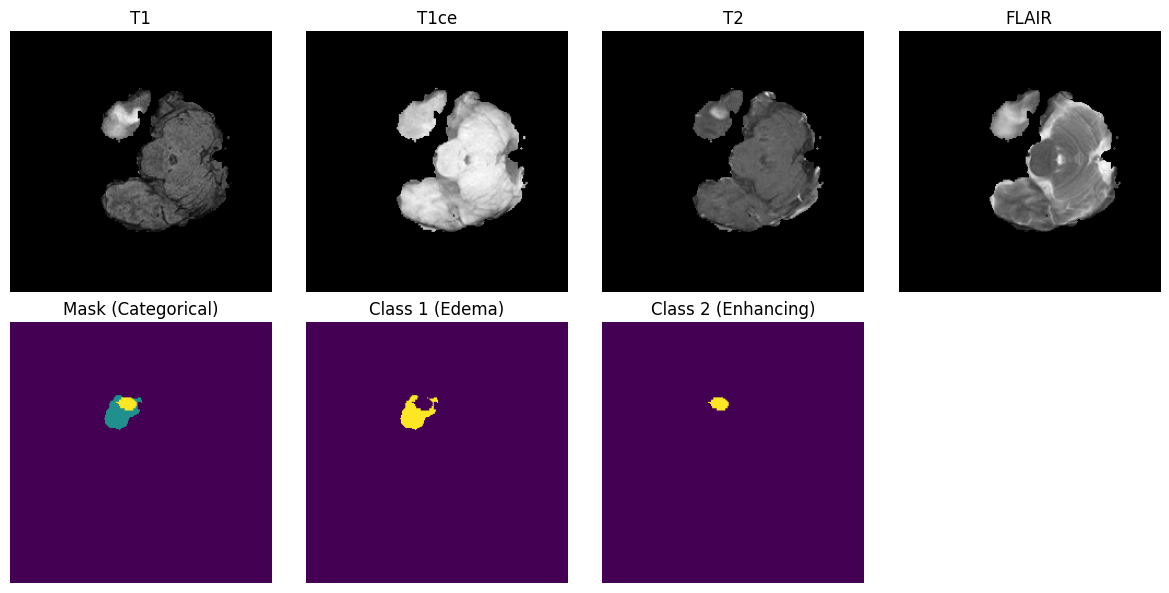

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# pick one slice file
fp = "/content/drive/MyDrive/BME-AIML-Final-Project/archive/BraTS2020_training_data/content/data/volume_200_slice_38.h5"


with h5py.File(fp, 'r') as f:
    img = f['image'][:]      # (240,240,4)
    mask = f['mask'][:]      # (240,240,3)

mask_int = np.argmax(mask, axis=-1)

plt.figure(figsize=(12,6))

# MRI modalities
mods = ["T1", "T1ce", "T2", "FLAIR"]
for i in range(4):
    plt.subplot(2,4,i+1)
    plt.imshow(img[:,:,i], cmap='gray')
    plt.title(mods[i])
    plt.axis('off')

# Mask
plt.subplot(2,4,5)
plt.imshow(mask_int)
plt.title("Mask (Categorical)")
plt.axis('off')

# Legend-like colors
plt.subplot(2,4,6)
plt.imshow(mask[:,:,1]) # class 1 channel
plt.title("Class 1 (Edema)")
plt.axis('off')

plt.subplot(2,4,7)
plt.imshow(mask[:,:,2])
plt.title("Class 2 (Enhancing)")
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import h5py

file_path = "/content/drive/MyDrive/BME-AIML-Final-Project/archive/BraTS2020_training_data/content/data/volume_200_slice_38.h5"
with h5py.File(file_path, 'r') as f:
    print("Keys:", list(f.keys()))
    print("Image shape:", f['image'].shape)
    print("Mask shape:", f['mask'].shape)
    print("Image min/max:", f['image'][:].min(), f['image'][:].max())
    print("Mask unique values:", np.unique(f['mask'][:]))


Keys: ['image', 'mask']
Image shape: (240, 240, 4)
Mask shape: (240, 240, 3)
Image min/max: -0.458984498864448 6.9094707753545865
Mask unique values: [0 1]
